# Installation and Imports

In [2]:
# pyFUME & other packages installation
!pip install pyFUME

In [9]:
# libraries imports

# Read and Pre-process the dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Fuzzy set and model
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester

# Model Performance
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score, mean_squared_error
from numpy import clip, column_stack, argmax

# Plots
import matplotlib.pyplot as plt


# Pre-Process dataset


In [5]:
# Loading the dataset
data = pd.read_csv('/content/wbco.csv',sep=',',header = None, names=['x1','x2','x3','x4','x5','x6','x7','x8','x9','y'])
print(data.head(20))

# Variables' names
features = data.columns[:-1]
print(features)

# Display data information (check for missing values, data types)
print(data.info())

# Check the distribution of the class labels
print(data['y'].value_counts())

# Replace '?' with NaN
data.replace('?', np.nan, inplace=True)

# Check for missing values
print(data.isnull().sum())

#  Drop rows with missing values
data_cleaned = data.dropna(how = 'any')

# Convert a specific column to int64
data_cleaned['x6'] = pd.to_numeric(data_cleaned['x6'], errors='coerce')

# Display data information (check for missing values, data types)
print(data_cleaned.info())

# Check the distribution of the class labels
print(data_cleaned['y'].value_counts())


    x1  x2  x3  x4  x5  x6  x7  x8  x9  y
0    5   1   1   1   2   1   3   1   1  0
1    5   4   4   5   7  10   3   2   1  0
2    3   1   1   1   2   2   3   1   1  0
3    6   8   8   1   3   4   3   7   1  0
4    4   1   1   3   2   1   3   1   1  0
5    8  10  10   8   7  10   9   7   1  1
6    1   1   1   1   2  10   3   1   1  0
7    2   1   2   1   2   1   3   1   1  0
8    2   1   1   1   2   1   1   1   5  0
9    4   2   1   1   2   1   2   1   1  0
10   1   1   1   1   1   1   3   1   1  0
11   2   1   1   1   2   1   2   1   1  0
12   5   3   3   3   2   3   4   4   1  1
13   1   1   1   1   2   3   3   1   1  0
14   8   7   5  10   7   9   5   5   4  1
15   7   4   6   4   6   1   4   3   1  1
16   4   1   1   1   2   1   2   1   1  0
17   4   1   1   1   2   1   3   1   1  0
18  10   7   7   6   4  10   4   1   2  1
19   6   1   1   1   2   1   3   1   1  0
Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Ra

<ipython-input-5-6eccd2be9596>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['x6'] = pd.to_numeric(data_cleaned['x6'], errors='coerce')


In [28]:
df = data_cleaned.to_numpy()
X = df[:,:-1]
y = df[:,-1]

# Spliting the dataset in a train set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model


In [29]:
ncl = [2, 3, 5, 8,10]
mtd = ['fcm','gk']
glb_ft = [True , False]

globaly_acc = []
globaly_rec = []
globaly_prec = []
globaly_F1 = []
globaly_kappa = []


locally_acc = []
locally_rec = []
locally_prec = []
locally_F1 = []
locally_kappa = []



for ft in glb_ft:
  for mth in mtd:
    for n in ncl:
      if ft == True:
        opt_ft = 'global'
      else:
        opt_ft = 'local'

      # Cluster training data
      cl = Clusterer(n,X_train,y_train)
      cluster_centers , partition_matrix, _ = cl.cluster(method = mth)

      # Estimate the membership functions of the system. default: mf_shape = gaussian
      ae = AntecedentEstimator(X_train, partition_matrix)
      antecedent_params = ae.determineMF()

      # Estimate the parameters of the consequence.
      ce = ConsequentEstimator(X_train,y_train, partition_matrix)
      consequent_params = ce.suglms(global_fit=ft)

      # %% Build first-order Takagi-Sugeno model
      modbuilder = SugenoFISBuilder(antecedent_params, consequent_params, features, save_simpful_code=False)
      model = modbuilder.get_model()

      # %% Get model predictions
      modtester = SugenoFISTester(model, X_test, features)
      y_pred_probs = clip(modtester.predict()[0], 0, 1)
      y_pred_probs = column_stack((1 - y_pred_probs, y_pred_probs))
      y_pred = argmax(y_pred_probs,axis=1)

      print("The following values were obtained for {} clusters, by method {} doing a {} optimization.".format(n,mth,opt_ft))

      # %% Compute regression metrics
      acc = accuracy_score(y_test, y_pred)
      print("Accuracy: {:.3f}".format(acc))
      rec = recall_score(y_test, y_pred)
      print("Recall: {:.3f}".format(rec))
      prec = precision_score(y_test, y_pred)
      print("Precision Score: {:.3f}".format(prec))
      F1_score = f1_score(y_test, y_pred)
      print("F1-Score: {:.3f}".format(F1_score))
      kappa = cohen_kappa_score(y_test, y_pred)
      print("Kappa Score: {:.3f}".format(kappa))


      if ft==True:

        globaly_acc.append(acc)
        globaly_rec.append(rec)
        globaly_prec.append(prec)
        globaly_F1.append(F1_score)
        globaly_kappa.append(kappa)

      else:

        locally_acc.append(acc)
        locally_rec.append(rec)
        locally_prec.append(prec)
        locally_F1.append(F1_score)
        locally_kappa.append(kappa)





 * Detected 2 rules / clusters
 * Detected Sugeno model type
The following values were obtained for 2 clusters, by method fcm doing a global optimization.
Accuracy: 0.873
Recall: 1.000
Precision Score: 0.750
F1-Score: 0.857
Kappa Score: 0.747
 * Detected 3 rules / clusters
 * Detected Sugeno model type
The following values were obtained for 3 clusters, by method fcm doing a global optimization.
Accuracy: 0.922
Recall: 1.000
Precision Score: 0.830
F1-Score: 0.907
Kappa Score: 0.841
 * Detected 5 rules / clusters
 * Detected Sugeno model type
The following values were obtained for 5 clusters, by method fcm doing a global optimization.
Accuracy: 0.844
Recall: 0.590
Precision Score: 1.000
F1-Score: 0.742
Kappa Score: 0.640
 * Detected 8 rules / clusters
 * Detected Sugeno model type
The following values were obtained for 8 clusters, by method fcm doing a global optimization.
Accuracy: 0.829
Recall: 0.590
Precision Score: 0.939
F1-Score: 0.724
Kappa Score: 0.610
 * Detected 10 rules / clust

In [ ]:
# Plots
# Fazer confusion matrix para o melhor modelo
# fazer plot das accuracy vs numero de clusters

In [13]:
print(globaly_acc)
print(ncl[2:])

[0.8731707317073171, 0.9219512195121952, 0.8439024390243902, 0.8292682926829268, 0.3804878048780488, 0.5170731707317073, 0.5853658536585366, 0.5170731707317073]
[5, 8]


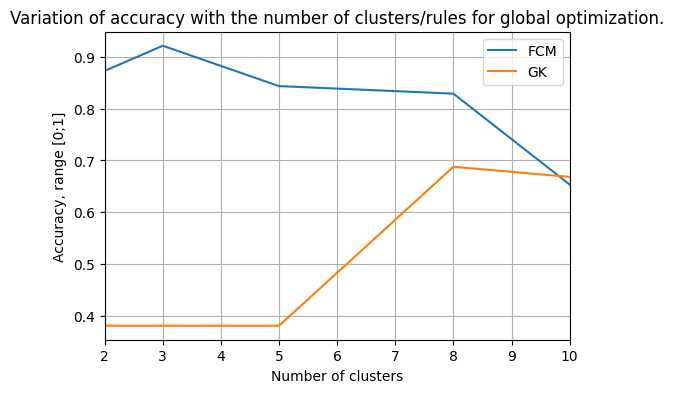

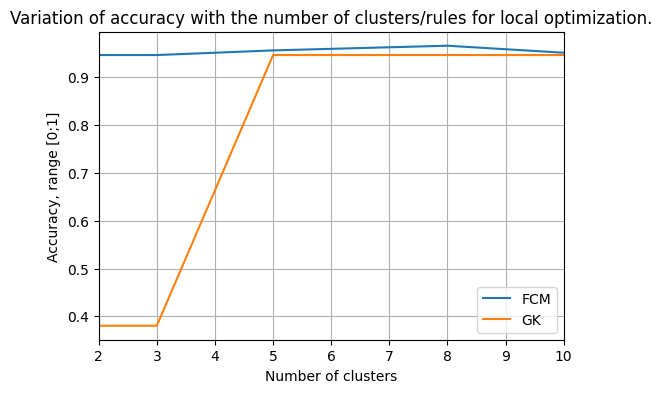

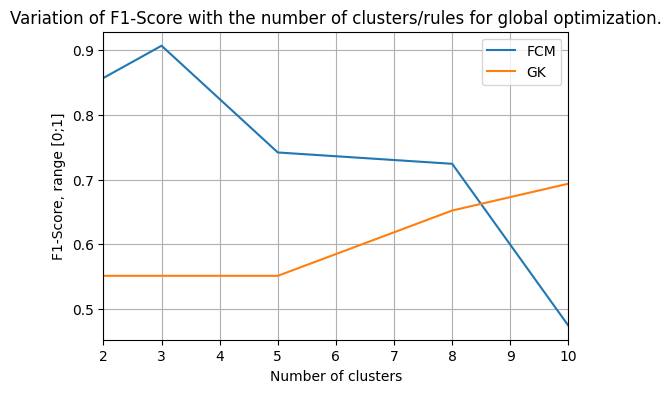

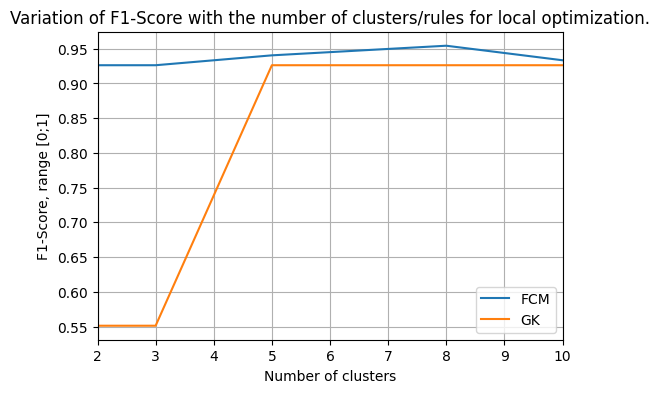

In [33]:
# Accuracy

plt.figure(figsize=(6,4))
plt.plot(ncl,globaly_acc[:len(ncl)], label='FCM')
plt.plot(ncl,globaly_acc[len(ncl):],label='GK')
plt.xlim(2, 10)
plt.title('Variation of accuracy with the number of clusters/rules for global optimization.')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy, range [0;1]')
plt.legend()
plt.grid()

plt.figure(figsize=(6,4))
plt.plot(ncl,locally_acc[:len(ncl)], label='FCM')
plt.plot(ncl,locally_acc[len(ncl):],label='GK')
plt.xlim(2, 10)
plt.title('Variation of accuracy with the number of clusters/rules for local optimization.')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy, range [0;1]')
plt.legend()
plt.grid()

# F1 - Score
plt.figure(figsize=(6,4))
plt.plot(ncl,globaly_F1[:len(ncl)], label='FCM')
plt.plot(ncl,globaly_F1[len(ncl):],label='GK')
plt.xlim(2, 10)
plt.title('Variation of F1-Score with the number of clusters/rules for global optimization.')
plt.xlabel('Number of clusters')
plt.ylabel('F1-Score, range [0;1]')
plt.legend()
plt.grid()

plt.figure(figsize=(6,4))
plt.plot(ncl,locally_F1[:len(ncl)], label='FCM')
plt.plot(ncl,locally_F1[len(ncl):],label='GK')
plt.xlim(2, 10)
plt.title('Variation of F1-Score with the number of clusters/rules for local optimization.')
plt.xlabel('Number of clusters')
plt.ylabel('F1-Score, range [0;1]')
plt.legend()
plt.grid()

# Lixo
